C:\Users\Alex\Documents\GitHub\MetPy\metpy\mapping\mpmap.py:106: UserWarning: Did not recognize the following features: bogus 
  warnings.warn(message)


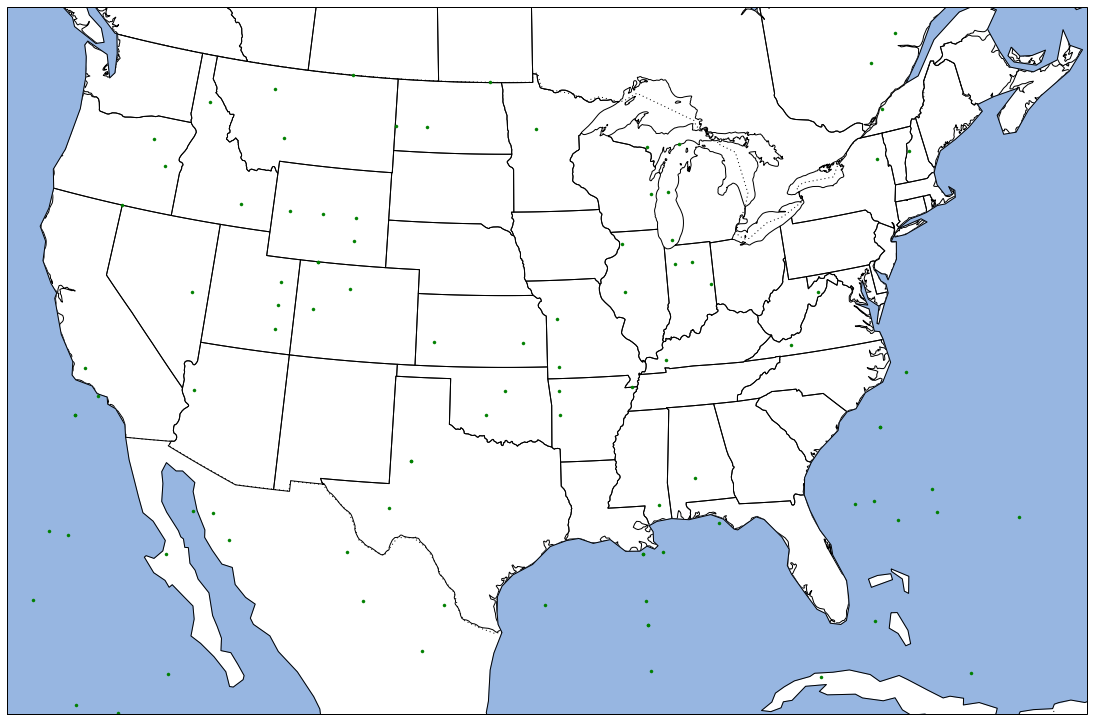

In [4]:
from metpy.mapping.mpmap import StationMap, MetpyMap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import cartopy.crs as ccrs

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

options = {"data_file": "C:/Documents/Stuff.txt",
           "data_type": "txt",
           "variable_to_plot": "air_temperature",
           "map_params": {"bbox": {"north": 50, "south": 20, "east": -70, "west": -120},
                          "features": ["coastlines", "ocean", "countries", "states", "bogus"]},
           "projection_options": {"from_proj": from_proj, "to_proj": to_proj}
           }



view = plt.axes([0, 0, 1, 1], projection=to_proj)
    
sfc_map = StationMap(options)

view = sfc_map.draw_map(view)

In [2]:
import numpy as np

x = np.random.randint(-120, -70, 100)
y = np.random.randint(35, 50, 100)

to_proj.transform_points(from_proj, x, y)[:,:2]

array([[  1.10059731e+06,   6.92949774e+04],
       [ -6.69524141e+05,   1.40745860e+05],
       [  9.49968267e+05,   6.28182864e+05],
       [ -4.07616516e+05,   3.54075094e+05],
       [ -1.61265768e+06,   1.31205826e+06],
       [  7.26611794e+05,   1.28706321e+06],
       [ -9.76464714e+05,   4.00954564e+05],
       [ -1.49295523e+06,  -2.21520365e+05],
       [  1.13662189e+06,   9.96804293e+05],
       [  1.47818347e+06,   8.23253315e+05],
       [ -1.24683017e+06,   7.83709597e+05],
       [  1.28541857e+06,  -2.14396100e+04],
       [  7.48311466e+05,   1.06344434e+06],
       [ -1.13662189e+06,   9.96804293e+05],
       [  1.35274210e+06,   1.04896326e+05],
       [  1.99256530e+06,   3.47173531e+05],
       [  9.23584351e+05,   8.54446127e+05],
       [  1.18595943e+06,   6.59178129e+05],
       [ -5.29010785e+05,  -3.29200026e+05],
       [  7.81169265e+05,   7.24839046e+05],
       [  9.43578501e+05,   1.31129998e+06],
       [ -4.07616516e+05,   3.54075094e+05],
       [ -